Regression Task

Author: Danil Kopysov (10742374)


In this script there are all of the steps I have made to prepare the solution. The code is splited into several sections:
- Data Import and preparation
- Variables transformation
- Division into subsets and preparation for regression
- OLS
- Ridge
- Lasso
- Tree
- Random forest
- SVR

The most effective in terms of MAE measure is the Random Forest model. So, it would be the main algorithm for further work.

In [4]:
import pandas as pd
data = pd.read_csv('train2.csv')
del data['Unnamed: 0']
data.head(5)

,dteday,hr,holiday,weekday,workingday,season_t,weather,temperature,s_temp,humidity,winds,n_employee,exp_employee,occupancy
0,2011-05-19,1,0,4,1,summer,Clear,20.50,24.240,94,0.0,2.67,9.29,6
1,2012-08-19,18,0,0,0,fall,Cloudy,26.24,29.545,78,7.0,2.67,3.57,377
2,2011-09-24,8,0,6,0,winter,Cloudy,23.78,27.275,90,6.0,2.67,28.00,121
3,2012-11-05,4,0,1,1,winter,Cloudy,12.30,14.395,52,17.0,2.67,4.57,16
4,2011-11-12,0,0,6,0,winter,Clear,9.84,12.120,60,9.0,1.67,7.57,64


In [5]:
#Amount of NaNs by variables
print(data.isna().sum())

dteday          0
hr              0
holiday         0
weekday         0
workingday      0
season_t        0
weather         0
temperature     0
s_temp          0
humidity        0
winds           0
n_employee      0
exp_employee    0
occupancy       0
dtype: int64


In [6]:
#Transformation of date into day, month and year
year=[]
for i in range(0, len(data['dteday'])):
    year.append(int(data['dteday'][i][0:4]))
year=pd.Series(year)
    
month = []
for i in range(0, len(data['dteday'])):
    month.append(int(data['dteday'][i][5:7]))
month=pd.Series(month)
    
day = []    
for i in range(0, len(data['dteday'])):
    day.append(int(data['dteday'][i][8:10]))
day=pd.Series(day)

In [7]:
#Merging and sanity check
date_new = pd.concat([day, month, year], join = 'inner', axis = 1)
date_new.columns = ['day', 'month', 'year']

date_new1 = pd.merge(date_new, data['dteday'], right_index = True, left_index = True)

In [8]:
data_cor =pd.merge(data, date_new, left_index = True, right_index = True)
#data_cor

In [9]:
#Transformation of date into ordinal values
data_cor['date_ord'] = pd.to_datetime(data['dteday']).apply(lambda dteday: dteday.toordinal())
#data_cor

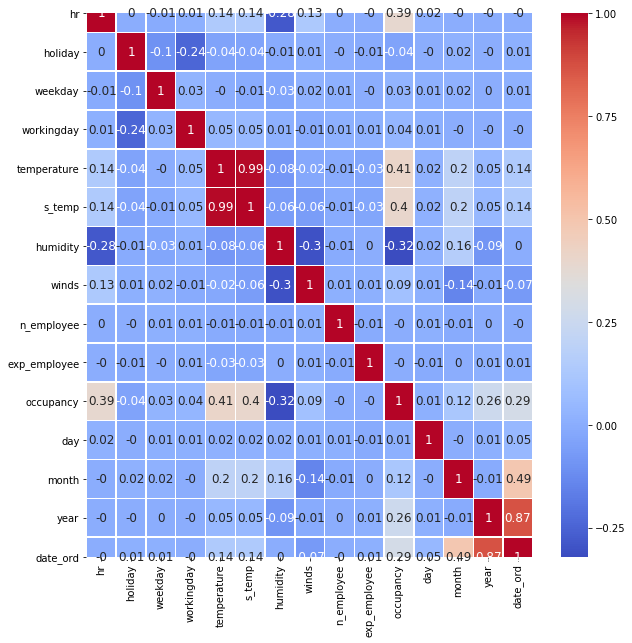

In [10]:
#correlation matrix
data_cor.corr().round(2)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (10,10))
sns.heatmap(data=data_cor.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

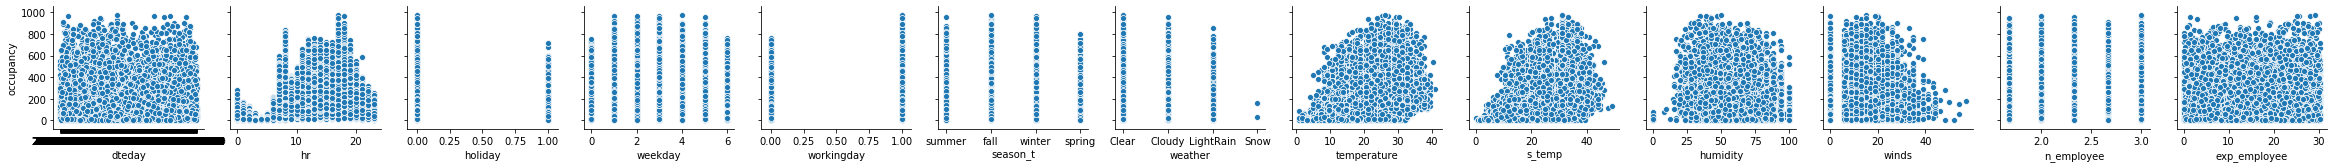

In [11]:
# visualize the relationship between the features and the response using scatterplots
%matplotlib inline
import seaborn as sns
sns.pairplot(data_cor, x_vars=list(data)[:-1], y_vars='occupancy')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000242294EB908>,
      dtype=object)

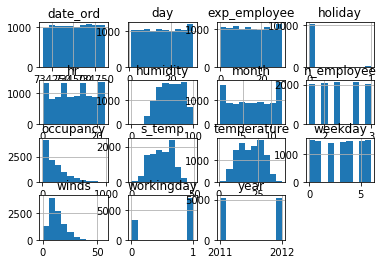

In [12]:
#distributions
data_cor.hist()

In [13]:
#Numerical vars standartization
num_var = [
 'temperature',
 's_temp',
 'humidity',
 'winds',
 'n_employee',
 'exp_employee']
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data_cor[num_var]) 
scaled_data_num = pd.DataFrame(scaler.transform(data_cor[num_var]))
scaled_data_num.columns = ['temperature_sc', 's_temp_sc',  'humidity_sc', 'winds_sc', 'n_employee_sc', 'exp_employee_sc']
scaled_data_num.apply(lambda s: scaled_data_num.corrwith(s))


,temperature_sc,s_temp_sc,humidity_sc,winds_sc,n_employee_sc,exp_employee_sc
temperature_sc,1.000000,0.989680,-0.075741,-0.022414,-0.013608,-0.027093
s_temp_sc,0.989680,1.000000,-0.060052,-0.060224,-0.013551,-0.026548
humidity_sc,-0.075741,-0.060052,1.000000,-0.295253,-0.013365,0.000306
winds_sc,-0.022414,-0.060224,-0.295253,1.000000,0.006372,0.010031
n_employee_sc,-0.013608,-0.013551,-0.013365,0.006372,1.000000,-0.013474
exp_employee_sc,-0.027093,-0.026548,0.000306,0.010031,-0.013474,1.000000


In [14]:
#PCA
from sklearn.decomposition import PCA
pca2 = PCA()
pca2.fit(scaled_data_num) 
df_pca = pd.DataFrame(pca2.transform(scaled_data_num))
explained_var=pd.DataFrame(pca2.explained_variance_ratio_).transpose()
explained_var

,0,1,2,3,4,5
0,0.333609,0.215957,0.168897,0.164021,0.115918,0.001598


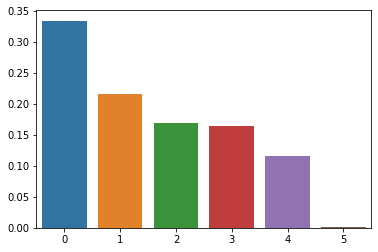

In [15]:
%matplotlib inline
import seaborn as sns
ax = sns.barplot( data=explained_var)

## Variables transformation

In [16]:
data_bin = data_cor[['hr', 'weekday', 'season_t', 'weather', 'day', 'month', 'year']].copy()

In [17]:
#categories binning
import pandas as pd
import numpy as np
 
#binning hours
bin_hrs = [-1,6,12,18,24]
category_hr = pd.cut(data_bin.hr, bin_hrs, labels = ['0-6', '7-12', '13-18', '19-23'])
category_hr = category_hr.to_frame()
category_hr.columns = ['hours']

#binning days
bin_days = [0, 11, 21, 31]
category_day = pd.cut(data_bin.day, bin_days, labels = ['week1', 'week2', 'week3']).to_frame() 
category_day.columns = ['day']

#reducing weather
data_bin.weather.loc[(data_bin.weather == 'Snow')] = 'Osadki'
data_bin.weather.loc[(data_bin.weather == 'LightRain')] = 'Osadki'

#sanity check
df_check = pd.concat([data_bin['hr'], category_hr, data_bin['day'], category_day, ], axis = 1)

C:\Users\xiaomi\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
data_bin_conc = pd.concat([category_hr, category_day, data_bin[['month', 'year', 'weekday', 'weather','season_t']], 
                           data_cor['hr']], axis = 1)
data_bin_conc.head()

,hours,day,month,year,weekday,weather,season_t,hr
0,0-6,week2,5,2011,4,Clear,summer,1
1,13-18,week2,8,2012,0,Cloudy,fall,18
2,7-12,week3,9,2011,6,Cloudy,winter,8
3,0-6,week1,11,2012,1,Cloudy,winter,4
4,0-6,week2,11,2011,6,Clear,winter,0


In [19]:
# Transformation to dummies - a lot of variables
data_bin2 = pd.get_dummies(data_bin_conc, columns=['hours', 'day', 'month', 'year', 'weekday', 'weather', 'season_t', 'hr'], 
                          prefix = ['hours', 'day', 'month', 'year', 'weekday', 'weather', 'season_t', 'hr'])
data_bin2.shape

(10427, 59)

In [20]:
#concat all of the data
final = pd.concat([data_cor[['temperature', 'humidity', 'winds', 'n_employee', 'exp_employee', 'date_ord']], data_bin2, data[['workingday', 'holiday', 'hr']],
                   data_cor[['day', 'month']], 
                   scaled_data_num[['temperature_sc', 's_temp_sc',  'humidity_sc', 'winds_sc', 'n_employee_sc', 'exp_employee_sc']],
                   data['occupancy']], axis = 1)
list(final)


['temperature',
 'humidity',
 'winds',
 'n_employee',
 'exp_employee',
 'date_ord',
 'hours_0-6',
 'hours_7-12',
 'hours_13-18',
 'hours_19-23',
 'day_week1',
 'day_week2',
 'day_week3',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'year_2011',
 'year_2012',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weather_Clear',
 'weather_Cloudy',
 'weather_Osadki',
 'season_t_fall',
 'season_t_spring',
 'season_t_summer',
 'season_t_winter',
 'hr_0',
 'hr_1',
 'hr_2',
 'hr_3',
 'hr_4',
 'hr_5',
 'hr_6',
 'hr_7',
 'hr_8',
 'hr_9',
 'hr_10',
 'hr_11',
 'hr_12',
 'hr_13',
 'hr_14',
 'hr_15',
 'hr_16',
 'hr_17',
 'hr_18',
 'hr_19',
 'hr_20',
 'hr_21',
 'hr_22',
 'hr_23',
 'workingday',
 'holiday',
 'hr',
 'day',
 'month',
 'temperature_sc',
 's_temp_sc',
 'humidity_sc',
 'winds_sc',
 'n_employee_sc',
 'exp_employee_sc',
 'occupancy']

## OLS

In [71]:
X=final.loc[:,
 ['temperature',
 'humidity',
 'winds',
 #'n_employee',
 #'exp_employee',
 'date_ord',
 #'hours_0-6',
 #'hours_7-12',
 #'hours_13-18',
 #'hours_19-23',
 #'day_week1',
 #'day_week2',
 #'day_week3',
 #'month_1',
 ##'month_2',
 #'month_3',
 #'month_4',
 ##'month_5',
 #'month_6',
 #'month_7',
 #'month_8',
 #'month_9',
 #'month_10',
 #'month_11',
 #'month_12',
 #'year_2011',
 #'year_2012',
 #'weekday_0',
 #'weekday_1',
 #'weekday_2',
 #'weekday_3',
 #'weekday_4',
 #'weekday_5',
 #'weekday_6',
 'weather_Clear',
 'weather_Cloudy',
 'weather_Osadki',
 'season_t_fall',
 'season_t_spring',
 'season_t_summer',
 'season_t_winter',
 'hr_0',
 'hr_1',
 'hr_2',
 'hr_3',
 'hr_4',
 'hr_5',
 'hr_6',
 'hr_7',
 'hr_8',
 'hr_9',
 'hr_10',
 'hr_11',
 'hr_12',
 'hr_13',
 'hr_14',
 'hr_15',
 'hr_16',
 'hr_17',
 'hr_18',
 'hr_19',
 'hr_20',
 'hr_21',
 'hr_22',
 'hr_23',
 #'workingday',
 'holiday',
 #'hr',
 #'day',
 #'month',
 #'temperature_sc',
 #'s_temp_sc',
 #'humidity_sc',
 #'winds_sc',
 #'n_employee_sc',
 #'exp_employee_sc'
 ]           
           ]
y = final.loc[:,['occupancy']]

In [72]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=123)

In [73]:
from sklearn.linear_model import LinearRegression
import numpy as np

regressor = LinearRegression() 
parameters = {}


from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(regressor, parameters,cv=3)

gs = gs.fit(X_train,y_train)


print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#test on hold-out

gs.score(X_train, y_train)
gs.score(X_test, y_test)

***GRIDSEARCH RESULTS***
Best score: 0.668683 using {}
0.668683 (0.007220) with: {}


0.6849784809697053

In [67]:
from sklearn import metrics

print("MAE train: ", metrics.mean_absolute_error(y_train, gs.predict(X_train))) 
print("MSE train: ",metrics.mean_squared_error(y_train, gs.predict(X_train)))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, gs.predict(X_train))))
print("r2: ",np.sqrt(metrics.r2_score(y_train, gs.predict(X_train))))

print("MAE test: ", metrics.mean_absolute_error(y_test, gs.predict(X_test))) 
print("MSE test: ",metrics.mean_squared_error(y_test, gs.predict(X_test)))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, gs.predict(X_test))))
print("r2: ",metrics.r2_score(y_test, gs.predict(X_test)))

MAE train:  76.9850855017401
MSE train:  11027.295667837865
RMSE train:  105.01093118260529
r2:  0.8206779402119796
MAE test:  75.23656495076926
MSE test:  10363.806426856514
RMSE test:  101.80278201923812
r2:  0.6849784809697053


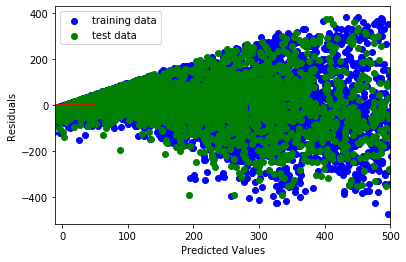

In [79]:
plt.scatter(gs.predict(X_train),error_train, c="b", label="training data")
plt.scatter(gs.predict(X_test),error_test, c="g", label="test data")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=-10, xmax=50, color="r")
plt.xlim([-10,500])

plt.show()

In [78]:
error_train=gs.predict(X_train)- y_train
error_test=gs.predict(X_test)- y_test


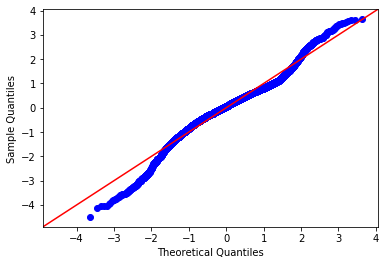

In [75]:
error_train = np.array(error_train).reshape(-1,1)
scaled_error_train= StandardScaler(copy=False).fit(error_train).transform(error_train).flatten()

import statsmodels.api as sm
from matplotlib import pyplot as plt

fig = sm.qqplot(scaled_error_train,line='45')
plt.show()

In [80]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

X_train = sm.add_constant(X_train)
#If we want to add a constant to our model 
est = sm.OLS(y_train, X_train)
est_fit = est.fit()
est_fit.params

print(est_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              occupancy   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     454.1
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:09:26   Log-Likelihood:                -44321.
No. Observations:                7298   AIC:                         8.871e+04
Df Residuals:                    7264   BIC:                         8.894e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -9.495e+04   2933.768    -

C:\Users\xiaomi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [81]:
# Kolmogorov-Smirnov Test
from scipy import stats
print(stats.kstest(scaled_error_train, 'norm'))

# D’Agostino Test
print(stats.normaltest(scaled_error_train))

KstestResult(statistic=0.06416630827852027, pvalue=1.5904677171484913e-26)
NormaltestResult(statistic=477.0577224441463, pvalue=2.559951848942174e-104)


## Tree 

In [82]:
X=final.loc[:,
 ['temperature',
 'humidity',
 'winds',
 #'n_employee',
 #'exp_employee',
 'date_ord',
 #'hours_0-6',
 #'hours_7-12',
 #'hours_13-18',
 #'hours_19-23',
 #'day_week1',
 #'day_week2',
 #'day_week3',
 #'month_1',
 ##'month_2',
 #'month_3',
 #'month_4',
 ##'month_5',
 #'month_6',
 #'month_7',
 #'month_8',
 #'month_9',
 #'month_10',
 #'month_11',
 #'month_12',
 #'year_2011',
 #'year_2012',
 #'weekday_0',
 #'weekday_1',
 #'weekday_2',
 #'weekday_3',
 #'weekday_4',
 #'weekday_5',
 #'weekday_6',
 'weather_Clear',
 'weather_Cloudy',
 'weather_Osadki',
 'season_t_fall',
 'season_t_spring',
 'season_t_summer',
 'season_t_winter',
 'hr_0',
 'hr_1',
 'hr_2',
 'hr_3',
 'hr_4',
 'hr_5',
 'hr_6',
 'hr_7',
 'hr_8',
 'hr_9',
 'hr_10',
 'hr_11',
 'hr_12',
 'hr_13',
 'hr_14',
 'hr_15',
 'hr_16',
 'hr_17',
 'hr_18',
 'hr_19',
 'hr_20',
 'hr_21',
 'hr_22',
 'hr_23',
 #'workingday',
 'holiday',
 #'hr',
 #'day',
 #'month',
 #'temperature_sc',
 #'s_temp_sc',
 #'humidity_sc',
 #'winds_sc',
 #'n_employee_sc',
 #'exp_employee_sc'
 ]           
           ]
y = final.loc[:,['occupancy']]

from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=123)

In [83]:
#DEFINE YOUR REGRESSOR and THE PARAMETERS GRID
from sklearn.tree import DecisionTreeRegressor 
import numpy as np

regressor = DecisionTreeRegressor()
parameters = {"max_depth":[3,4,5,6,7,8,9,10], 
              "min_samples_leaf": [0.1, 0.15, 0.05, 0.01]}

#DEFINE YOUR GRIDSEARCH 
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(regressor, parameters, cv=3) #with no params it reduces to a CV

gs = gs.fit(X_train,y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#Returns the coefficient of determination R^2 of the prediction.
#Explained variance score: 1 is perfect prediction
gs.score(X_test, y_test)

***GRIDSEARCH RESULTS***
Best score: 0.523355 using {'max_depth': 10, 'min_samples_leaf': 0.01}
0.265451 (0.008814) with: {'max_depth': 3, 'min_samples_leaf': 0.1}
0.219745 (0.008265) with: {'max_depth': 3, 'min_samples_leaf': 0.15}
0.278836 (0.008619) with: {'max_depth': 3, 'min_samples_leaf': 0.05}
0.317211 (0.040542) with: {'max_depth': 3, 'min_samples_leaf': 0.01}
0.266123 (0.009099) with: {'max_depth': 4, 'min_samples_leaf': 0.1}
0.219745 (0.008265) with: {'max_depth': 4, 'min_samples_leaf': 0.15}
0.300624 (0.012861) with: {'max_depth': 4, 'min_samples_leaf': 0.05}
0.382719 (0.033441) with: {'max_depth': 4, 'min_samples_leaf': 0.01}
0.266123 (0.009099) with: {'max_depth': 5, 'min_samples_leaf': 0.1}
0.219745 (0.008265) with: {'max_depth': 5, 'min_samples_leaf': 0.15}
0.302636 (0.011744) with: {'max_depth': 5, 'min_samples_leaf': 0.05}
0.432909 (0.017715) with: {'max_depth': 5, 'min_samples_leaf': 0.01}
0.266123 (0.009099) with: {'max_depth': 6, 'min_samples_leaf': 0.1}
0.219745 (0

0.5080869362262115

In [84]:
from sklearn import metrics

print("MAE train: ", metrics.mean_absolute_error(y_train, gs.predict(X_train))) 
print("MSE train: ",metrics.mean_squared_error(y_train, gs.predict(X_train)))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, gs.predict(X_train))))
print("r2: ",np.sqrt(metrics.r2_score(y_train, gs.predict(X_train))))

print("MAE test: ", metrics.mean_absolute_error(y_test, gs.predict(X_test))) 
print("MSE test: ",metrics.mean_squared_error(y_test, gs.predict(X_test)))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, gs.predict(X_test))))
print("r2: ",metrics.r2_score(y_test, gs.predict(X_test)))

MAE train:  92.3948482047547
MSE train:  15721.209458217198
RMSE train:  125.3842472490751
r2:  0.7311213850077963
MAE test:  94.4956992972609
MSE test:  16183.312770145065
RMSE test:  127.21365009363211
r2:  0.5080869362262115


In [85]:
#It is worse then previous

## Random Forest 

In [21]:
X=final.loc[:,
['temperature',
 'humidity',
 'winds',
 #'n_employee',
 #'exp_employee',
 'date_ord',
 #'hours_0-6',
 #'hours_7-12',
 #'hours_13-18',
 #'hours_19-23',
 #'day_week1',
 #'day_week2',
 #'day_week3',
 #'month_1',
 #'month_2',
 #'month_3',
 #'month_4',
 #'month_5',
 #'month_6',
 #'month_7',
 #'month_8',
 #'month_9',
 #'month_10',
 #'month_11',
 #'month_12',
 #'year_2011',
 #'year_2012',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weather_Clear',
 'weather_Cloudy',
 'weather_Osadki',
 'season_t_fall',
 'season_t_spring',
 'season_t_summer',
 'season_t_winter',
 #'hr_0',
 #'hr_1',
 #'hr_2',
 #'hr_3',
 #'hr_4',
 #'hr_5',
 #'hr_6',
 #'hr_7',
 #'hr_8',
 #'hr_9',
 #'hr_10',
 #'hr_11',
 #'hr_12',
 #'hr_13',
 #'hr_14',
 #'hr_15',
 #'hr_16',
 #'hr_17',
 #'hr_18',
 #'hr_19',
 #'hr_20',
 #'hr_21',
 #'hr_22',
 #'hr_23',
 'workingday',
 'holiday',
 'hr',
 #'day',
 #'month',
 #'temperature_sc',
 #'s_temp_sc',
 #'humidity_sc',
 #'winds_sc',
 #'n_employee_sc',
 #'exp_employee_sc',
 #'occupancy'
]]
y = final.loc[:,['occupancy']]

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=42)

#DEFINE YOUR REGRESSOR and THE PARAMETERS GRID
from sklearn.ensemble import RandomForestRegressor 
import numpy as np

regressor = RandomForestRegressor()
parameters = {"n_estimators":[500,1000], "criterion": ['mse'], 'min_samples_split': [2], 'max_depth': [10],
              "min_samples_leaf": [1,2], "random_state" : [42], 'max_features': ['auto']}

#DEFINE YOUR GRIDSEARCH 
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(regressor, parameters, cv=3) #with no params it reduces to a CV

gs = gs.fit(X_train,y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#Returns the coefficient of determination R^2 of the prediction.
#Explained variance score: 1 is perfect prediction
gs.score(X_test, y_test)

C:\Users\xiaomi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\xiaomi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\xiaomi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\xiaomi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector 

***GRIDSEARCH RESULTS***
Best score: 0.916413 using {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}
0.916413 (0.002573) with: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}
0.916148 (0.002811) with: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 42}
0.915340 (0.002235) with: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}
0.915158 (0.002438) with: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 42}


0.9217463155876013

In [23]:
from sklearn import metrics

print("MAE train: ", metrics.mean_absolute_error(y_train, gs.predict(X_train))) 
print("MSE train: ",metrics.mean_squared_error(y_train, gs.predict(X_train)))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, gs.predict(X_train))))
print("r2: ",np.sqrt(metrics.r2_score(y_train, gs.predict(X_train))))

print("MAE test: ", metrics.mean_absolute_error(y_test, gs.predict(X_test))) 
print("MSE test: ",metrics.mean_squared_error(y_test, gs.predict(X_test)))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, gs.predict(X_test))))
print("r2: ",metrics.r2_score(y_test, gs.predict(X_test)))

MAE train:  25.141769395893075
MSE train:  1580.6401995624076
RMSE train:  39.757265997077916
r2:  0.9760319513671245
MAE test:  31.754705200774012
MSE test:  2646.9299629702714
RMSE test:  51.44832322797577
r2:  0.9217463155876013


In [24]:
# Kolmogorov-Smirnov Test
from scipy import stats
print(stats.kstest(error_train, 'norm'))

# D’Agostino Test
print(stats.normaltest(error_train))

NameError: name 'error_train' is not defined

# Lasso, ridge

In [92]:
X=final.loc[:,
 ['temperature',
 'humidity',
 'winds',
 #'n_employee',
 #'exp_employee',
 'date_ord',
 #'hours_0-6',
 #'hours_7-12',
 #'hours_13-18',
 #'hours_19-23',
 #'day_week1',
 #'day_week2',
 #'day_week3',
 #'month_1',
 ##'month_2',
 #'month_3',
 #'month_4',
 ##'month_5',
 #'month_6',
 #'month_7',
 #'month_8',
 #'month_9',
 #'month_10',
 #'month_11',
 #'month_12',
 #'year_2011',
 #'year_2012',
 #'weekday_0',
 #'weekday_1',
 #'weekday_2',
 #'weekday_3',
 #'weekday_4',
 #'weekday_5',
 #'weekday_6',
 'weather_Clear',
 'weather_Cloudy',
 'weather_Osadki',
 'season_t_fall',
 'season_t_spring',
 'season_t_summer',
 'season_t_winter',
 'hr_0',
 'hr_1',
 'hr_2',
 'hr_3',
 'hr_4',
 'hr_5',
 'hr_6',
 'hr_7',
 'hr_8',
 'hr_9',
 'hr_10',
 'hr_11',
 'hr_12',
 'hr_13',
 'hr_14',
 'hr_15',
 'hr_16',
 'hr_17',
 'hr_18',
 'hr_19',
 'hr_20',
 'hr_21',
 'hr_22',
 'hr_23',
 #'workingday',
 'holiday',
 #'hr',
 #'day',
 #'month',
 #'temperature_sc',
 #'s_temp_sc',
 #'humidity_sc',
 #'winds_sc',
 #'n_employee_sc',
 #'exp_employee_sc'
 ]           
           ]
y = final.loc[:,['occupancy']]

In [93]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=123)

In [94]:
#Lasso 
    
#DEFINE YOUR REGRESSOR and THE PARAMETERS GRID
from sklearn.linear_model import Lasso
import numpy as np

regressor = Lasso()
parameters = {"alpha": [0.001,0.01,0.1,1,10], "normalize": [True, False]}

#DEFINE YOUR GRIDSEARCH 
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(regressor, parameters, cv=3) #with no params it reduces to a CV

gs = gs.fit(X_train,y_train)

lasso_coef = gs.best_estimator_.coef_
print(lasso_coef)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#test on hold-out
gs.score(X_test, y_test)

C:\Users\xiaomi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 903993.9266482815, tolerance: 16222.364719424462
  positive)
C:\Users\xiaomi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337121.829457283, tolerance: 16218.897268160332
  positive)
C:\Users\xiaomi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 982673.875774458, tolerance: 16854.858949136866
  positive)


[ 6.01719618e+00 -8.50459493e-01 -5.75076231e-01  2.10212971e-01
  1.13672571e+01 -0.00000000e+00 -4.67738121e+01 -2.41306653e+01
 -2.21084782e+01  1.17286329e+01  1.84093615e-02 -1.45665352e+02
 -1.54331788e+02 -1.66810631e+02 -1.86428843e+02 -1.83533605e+02
 -1.61990590e+02 -1.07237873e+02  2.92070004e+01  1.81725296e+02
  1.55217376e+01 -2.90533957e+01 -1.11127996e+01  2.46630405e+01
  3.32086478e+01  0.00000000e+00  6.77838917e+00  7.43315215e+01
  2.39396218e+02  1.90656842e+02  9.73353074e+01  1.71935467e+01
 -3.18289705e+01 -7.73243260e+01 -1.09736522e+02 -3.45590044e+01]
***GRIDSEARCH RESULTS***
Best score: 0.668686 using {'alpha': 0.01, 'normalize': False}
0.668681 (0.007208) with: {'alpha': 0.001, 'normalize': True}
0.668684 (0.007219) with: {'alpha': 0.001, 'normalize': False}
0.668245 (0.007140) with: {'alpha': 0.01, 'normalize': True}
0.668686 (0.007218) with: {'alpha': 0.01, 'normalize': False}
0.634671 (0.007837) with: {'alpha': 0.1, 'normalize': True}
0.668497 (0.007210

0.684972742662699

In [95]:
from sklearn import metrics

print("MAE train: ", metrics.mean_absolute_error(y_train, gs.predict(X_train))) 
print("MSE train: ",metrics.mean_squared_error(y_train, gs.predict(X_train)))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, gs.predict(X_train))))
print("r2: ",np.sqrt(metrics.r2_score(y_train, gs.predict(X_train))))

print("MAE test: ", metrics.mean_absolute_error(y_test, gs.predict(X_test))) 
print("MSE test: ",metrics.mean_squared_error(y_test, gs.predict(X_test)))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, gs.predict(X_test))))
print("r2: ",metrics.r2_score(y_test, gs.predict(X_test)))

MAE train:  76.97958673724905
MSE train:  11027.375688158383
RMSE train:  105.01131219139386
r2:  0.820676496781928
MAE test:  75.23268498400252
MSE test:  10363.995209842557
RMSE test:  101.80370921455935
r2:  0.684972742662699


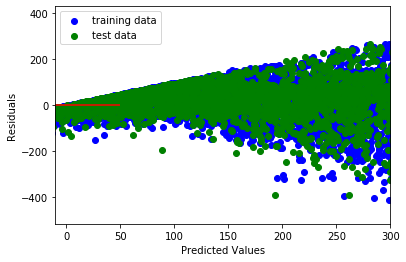

In [96]:
error_train = gs.predict(X_train)-np.array(y_train).flatten()
error_test = gs.predict(X_test)-np.array(y_test).flatten()

plt.scatter(gs.predict(X_train),error_train, c="b", label="training data")
plt.scatter(gs.predict(X_test),error_test, c="g", label="test data")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=-10, xmax=50, color="r")
plt.xlim([-10,300])
plt.show()

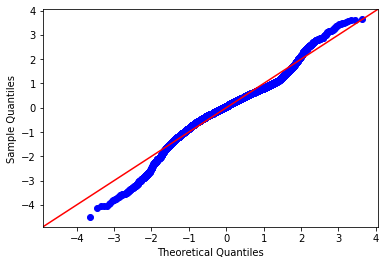

In [97]:
error_train = np.array(error_train).reshape(-1,1)
scaled_error_train= StandardScaler(copy=False).fit(error_train).transform(error_train).flatten()

import statsmodels.api as sm
from matplotlib import pyplot as plt

fig = sm.qqplot(scaled_error_train,line='45')
plt.show()

In [98]:
from scipy import stats
print(stats.kstest(scaled_error_train, 'norm'))

# D’Agostino Test
print(stats.normaltest(scaled_error_train))

KstestResult(statistic=0.06461724596670254, pvalue=6.813967100548774e-27)
NormaltestResult(statistic=480.630731563627, pvalue=4.2890659525738714e-105)


In [99]:
# Ridge
#DEFINE YOUR REGRESSOR and THE PARAMETERS GRID
from sklearn.linear_model import Ridge
import numpy as np

regressor = Ridge()

parameters = {"alpha": [0.001,0.01,0.1,1,10], "normalize": [True, False]}
#note that we set alpha using the argument alpha
#also notice the argument normalize: setting this equal to True ensures that all 
#our variables are on the same scale

#DEFINE YOUR GRIDSEARCH 
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(regressor, parameters, cv=3) #with no params it reduces to a CV

gs = gs.fit(X_train,y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#test on hold-out
gs.score(X_test, y_test)

***GRIDSEARCH RESULTS***
Best score: 0.668714 using {'alpha': 1, 'normalize': False}
0.668690 (0.007196) with: {'alpha': 0.001, 'normalize': True}
0.668683 (0.007220) with: {'alpha': 0.001, 'normalize': False}
0.668708 (0.006980) with: {'alpha': 0.01, 'normalize': True}
0.668683 (0.007220) with: {'alpha': 0.01, 'normalize': False}
0.665043 (0.005498) with: {'alpha': 0.1, 'normalize': True}
0.668687 (0.007214) with: {'alpha': 0.1, 'normalize': False}
0.544178 (0.008934) with: {'alpha': 1, 'normalize': True}
0.668714 (0.007161) with: {'alpha': 1, 'normalize': False}
0.158985 (0.004371) with: {'alpha': 10, 'normalize': True}
0.667943 (0.006772) with: {'alpha': 10, 'normalize': False}


0.6849825235802584

In [100]:
from sklearn import metrics

print("MAE train: ", metrics.mean_absolute_error(y_train, gs.predict(X_train))) 
print("MSE train: ",metrics.mean_squared_error(y_train, gs.predict(X_train)))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, gs.predict(X_train))))
print("r2: ",np.sqrt(metrics.r2_score(y_train, gs.predict(X_train))))

print("MAE test: ", metrics.mean_absolute_error(y_test, gs.predict(X_test))) 
print("MSE test: ",metrics.mean_squared_error(y_test, gs.predict(X_test)))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, gs.predict(X_test))))
print("r2: ",metrics.r2_score(y_test, gs.predict(X_test)))

MAE train:  76.98891263291699
MSE train:  11027.486328796373
RMSE train:  105.01183899349812
r2:  0.8206745010094117
MAE test:  75.243425637476
MSE test:  10363.673430122319
RMSE test:  101.80212880938355
r2:  0.6849825235802584


In [101]:
from scipy import stats
print(stats.kstest(scaled_error_train, 'norm'))

# D’Agostino Test
print(stats.normaltest(scaled_error_train))

KstestResult(statistic=0.06461724596670254, pvalue=6.813967100548774e-27)
NormaltestResult(statistic=480.630731563627, pvalue=4.2890659525738714e-105)


# prediction

In [25]:
import pandas as pd
data_pred = pd.read_csv('test_explanatory.csv')
del data_pred['Unnamed: 0']
data_pred.head(5)

,dteday,hr,holiday,weekday,workingday,season_t,weather,temperature,s_temp,humidity,winds,n_employee,exp_employee
0,2012-06-23,19,0,6,0,fall,Clear,32.80,34.850,27,13.0,2.67,1.14
1,2012-01-02,20,1,1,0,spring,Clear,9.84,11.365,41,15.0,2.67,20.00
2,2011-10-28,2,0,5,1,winter,Clear,13.12,15.150,66,19.0,2.00,28.86
3,2012-05-29,19,0,2,1,summer,Clear,31.98,35.605,52,24.0,2.00,2.29
4,2011-01-20,0,0,4,1,spring,Clear,10.66,11.365,56,26.0,3.00,16.43


In [26]:
len(data_pred)

6952

In [27]:
#feature transformation
#Transformation of date into ordinal values
data_pred1 = data_pred.copy()
data_pred1['date_ord'] = pd.to_datetime(data['dteday']).apply(lambda dteday: dteday.toordinal())
#data_cor

In [28]:
#reducing weather
data_pred1.weather.loc[(data_pred1.weather == 'Snow')] = 'Osadki'
data_pred1.weather.loc[(data_pred1.weather == 'LightRain')] = 'Osadki'

C:\Users\xiaomi\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
data_pred1.weather.unique()
data_pred1.head()


,dteday,hr,holiday,weekday,workingday,season_t,weather,temperature,s_temp,humidity,winds,n_employee,exp_employee,date_ord
0,2012-06-23,19,0,6,0,fall,Clear,32.80,34.850,27,13.0,2.67,1.14,734276
1,2012-01-02,20,1,1,0,spring,Clear,9.84,11.365,41,15.0,2.67,20.00,734734
2,2011-10-28,2,0,5,1,winter,Clear,13.12,15.150,66,19.0,2.00,28.86,734404
3,2012-05-29,19,0,2,1,summer,Clear,31.98,35.605,52,24.0,2.00,2.29,734812
4,2011-01-20,0,0,4,1,spring,Clear,10.66,11.365,56,26.0,3.00,16.43,734453


In [30]:
data_bin_concp = data_pred1[['weekday', 'weather','season_t']].copy()


# Transformation to dummies - a lot of variables
data_bin_pred = pd.get_dummies(data_bin_concp, columns=['weekday', 'weather', 'season_t'], 
                          prefix = ['weekday', 'weather', 'season_t'])
print(data_bin_pred.shape)

print(data_bin_pred.head())

(6952, 14)
   weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  \
0          0          0          0          0          0          0   
1          0          1          0          0          0          0   
2          0          0          0          0          0          1   
3          0          0          1          0          0          0   
4          0          0          0          0          1          0   

   weekday_6  weather_Clear  weather_Cloudy  weather_Osadki  season_t_fall  \
0          1              1               0               0              1   
1          0              1               0               0              0   
2          0              1               0               0              0   
3          0              1               0               0              0   
4          0              1               0               0              0   

   season_t_spring  season_t_summer  season_t_winter  
0                0                0   

In [31]:
final_pred = pd.concat([data_bin_pred, data_pred1[['temperature', 'humidity', 'winds', 'date_ord', 'workingday', 'holiday', 
                                                  'hr']]], axis = 1)

In [32]:
len(final_pred)

6952

## Model RF

In [33]:
X_train1 = final.loc[:,['temperature', 'humidity', 'winds', 'date_ord', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 
                     'weekday_4', 'weekday_5', 'weekday_6', 'weather_Clear', 'weather_Cloudy', 'weather_Osadki',
                     'season_t_fall', 'season_t_spring', 'season_t_summer', 'season_t_winter', 'workingday', 'holiday',
                     'hr']]
y_train1 = final.loc[:,['occupancy']]

In [34]:
X_train1.shape

(10427, 21)

In [35]:
X_train.shape

(7298, 21)

In [36]:
from sklearn.ensemble import RandomForestRegressor 
import numpy as np

regressor = RandomForestRegressor()
parameters = {"n_estimators":[500,1000], "criterion": ['mse'], 'min_samples_split': [2], 'max_depth': [10],
              "min_samples_leaf": [1,2], "random_state" : [42], 'max_features': ['auto']}

#DEFINE YOUR GRIDSEARCH 
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(regressor, parameters, cv=3) #with no params it reduces to a CV

gs = gs.fit(X_train1, y_train1)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\xiaomi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\xiaomi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\xiaomi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\xiaomi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector 

***GRIDSEARCH RESULTS***
Best score: 0.923186 using {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}
0.923186 (0.004145) with: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}
0.923160 (0.004378) with: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 42}
0.923023 (0.004352) with: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}
0.923092 (0.004443) with: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 42}


In [37]:
predicted_values = gs.predict(final_pred)

In [38]:
dred_val2 = gs.predict(final_pred)

In [39]:
pd.DataFrame(dred_val2).describe()

,0
count,6952.000000
mean,56.374335
std,42.294970
min,2.662690
25%,24.579524
50%,60.063459
75%,80.222564
max,157.012314


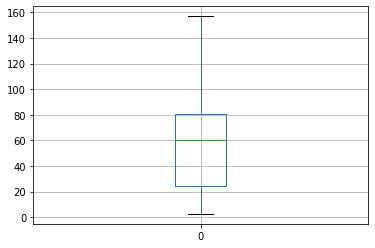

In [173]:
pd.DataFrame(predicted_values).boxplot()

In [157]:
len(predicted_values)

10427

In [40]:
#SAVE YOUR PREDICTION on a CSV file named with your StudentID
df_predict_reg = pd.DataFrame(predicted_values, columns=["target"])
df_predict_reg.to_csv("931750.csv", index = False)

In [41]:
final.occupancy.describe()

count    10427.000000
mean       191.480100
std        183.072824
min          1.000000
25%         40.000000
50%        145.000000
75%        282.000000
max        976.000000
Name: occupancy, dtype: float64

In [42]:
asdas = pd.DataFrame(predicted_values)
asdas.describe()

,0
count,6952.000000
mean,56.374335
std,42.294970
min,2.662690
25%,24.579524
50%,60.063459
75%,80.222564
max,157.012314
